Big Data And Society: Lab 3
=====


# APIs and Data Scraping: Getting Twitter Data

### Problem Set 3 - Extend What You Have Learned

Now that you know how to scrape data from Twitter, let's extend the exercise a little so you can show us what you know. This time you will set up the scraper to get data around MIT and scrape data for 30 minutes. Then you will visualize it with  and visualize. Think about what you would need to change to do that. 

Once you have the new JSON file of Boston tweets you should a pie chart and scatterplot of your collected tweets. When you are creating your dataset, you should get at least two different attributes returned by the Twitter API (we got many of them above, so base it off of that example). Atleast one of them should be the tweet id. Make sure you remove and duplicate tweets (if any). Expanding on the above, then save the data to a CSV.

Make sure you get your own Twitter Key.

#### Deliverables

**1** - Using the Twitter REST API, collect Tweets from Boston for 30 min. Note how you set the time in the above example (in the **run_all()** function), it was in seconds. How would you do that here? 

**2** - Create a Pie Chart showing a summary of tweets by user location. Please clean up the data so that multiple variations of the same location name are replaced with one variation.

**3** - Create a Scatterplot showing all of the tweets that had a latitude and longitude.

**4** - Pick a search term, such as *Trump* or *#Trump* and collect 15 minutes of tweets on it. Use the same lat/lon for Boston as you used above.

**5** - Export the entirety of your scraped Twitter datasets (one with a search term, one without) to two CSV files. We will be checking this CSV file for duplicates. So clean your file.  

### What to Give Us on Stellar 

1 - Create a new Jupyter notebook that contains your scraper code. You can copy much of this one, but customize it. Submit the new Jupyter notebook, which includes your pie chart and scatterplot.

2 - Your final CSV files. 


In [74]:
# Import!
import json
import time
import threading
from datetime import datetime
from twython import Twython
from twitter_key import api_key, api_secret
from os import listdir #allows us to get files from the computer
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [75]:
# Assigning twitter api keys to the variables
APP_KEY = api_key
APP_SECRET = api_secret

# Creating a Twython object called Twitter
# Seting this up using your Twitter Keys
twython_setup = Twython(APP_KEY, APP_SECRET, oauth_version=2)

# Get an OAuth2 access token, save as variable so we can launch our 
OAUTH2_ACCESS_TOKEN = twython_setup.obtain_access_token()

# Create a Twython Object we will use for our access to the API
my_twython = Twython(APP_KEY, access_token=OAUTH2_ACCESS_TOKEN)

In [5]:
search_term='' 
latlong=[42.383434,-71.103069] # Spring Hill, Somerville, MA
# Setup a search distance
distance='15mi'
# Set result type (can be 'popular', 'popular', or 'mixed')
type_of_result='recent'
# Set number of results (up to 100, remember you can only get 450 in 15 minutes)
number_of_tweets=5

def get_tweets_by_location( latlong=None ):
    results = my_twython.search(q=search_term, geocode=str(latlong[0])+','+str(latlong[1])+','+ distance, result_type=type_of_result, count=number_of_tweets)
    return results['statuses']

def get_lots_of_tweets( latlong ):
    all_tweets = {}
    
    # We will be hitting the API a number of times within the total time
    total_time = 1800
    
    # Everytime we hit the API we subtract time from the total
    remaining_seconds = total_time
    interval = 10
    while remaining_seconds > 0: # loop and run the function while remaining seconds is greater than zero
        added = 0
        new_tweets = get_tweets_by_location(latlong)
        # Parse the resulting JSON, and save the rest of the raw content
        for tweet in new_tweets:
            tid = tweet['id']
            if tid not in all_tweets:
                properties = {}
                if tweet['coordinates'] != None:
                    properties['lat'] = tweet['coordinates']['coordinates'][0]
                    properties['lon'] = tweet['coordinates']['coordinates'][1]
                else:
                    properties['lat'] = None
                    properties['lon'] = None
                properties['location'] = tweet['user']['location'] #This will get us the location associated with the profile
                properties['tweet_id'] = tid
                properties['content'] = tweet['text']
                all_tweets[ tid ] = properties
                added += 1
        print("At %d seconds, added %d new tweets, for a total of %d" % ( total_time - remaining_seconds, added, len( all_tweets )))
        time.sleep(interval)
        remaining_seconds -= interval
    print(str(len(all_tweets)) + ' Tweets retrieved.')
    return all_tweets


# This function executes the the functions over a given period of time
def run_all():
    # This is the number of times the code will be executed. In this case, just once. 
    starting = 1
    while starting > 0:
        # Sometimes the API returns some errors, killing the whole script, so we setup try/except to make sure it keeps running
        try:
            t = get_lots_of_tweets( latlong )
            # We name every file with the current time
            timestr = time.strftime("%Y%m%d-%H%M%S")
            # We write a new JSON into the target path
            with open( 'data/' + '%stweets.json' %(timestr), 'w' ) as f:
                f.write(json.dumps(t))
            # we can use a library like threading to execute the run function continuously.
            #threading.Timer(10, run).start()
            starting -= 1
        except:
            pass
    
run_all()

At 0 seconds, added 5 new tweets, for a total of 5
At 10 seconds, added 0 new tweets, for a total of 5
At 20 seconds, added 5 new tweets, for a total of 10
At 30 seconds, added 0 new tweets, for a total of 10
At 40 seconds, added 5 new tweets, for a total of 15
At 50 seconds, added 0 new tweets, for a total of 15
At 60 seconds, added 5 new tweets, for a total of 20
At 70 seconds, added 0 new tweets, for a total of 20
At 80 seconds, added 5 new tweets, for a total of 25
At 90 seconds, added 0 new tweets, for a total of 25
At 100 seconds, added 4 new tweets, for a total of 29
At 110 seconds, added 0 new tweets, for a total of 29
At 120 seconds, added 5 new tweets, for a total of 34
At 130 seconds, added 0 new tweets, for a total of 34
At 140 seconds, added 5 new tweets, for a total of 39
At 150 seconds, added 0 new tweets, for a total of 39
At 160 seconds, added 5 new tweets, for a total of 44
At 170 seconds, added 0 new tweets, for a total of 44
At 180 seconds, added 4 new tweets, for a

In [76]:
file_dir = "data/PSET"

onlyfiles = [ f for f in listdir(file_dir) if isfile(join(file_dir,f)) and not f.startswith('.')]

df_somervilletweets = pd.DataFrame(columns = ['tweet_id', 'lat', 'lon', 'content','location'])

for file in onlyfiles:
    full_dir = join(file_dir,file) 
    with open(full_dir) as json_data:
        dict = json.load(json_data) 
        if not isinstance(dict, list):
            for key, val in dict.items():
                df_somervilletweets.loc[key,val] = val
                
df_somervilletweets

,tweet_id,lat,lon,content,location
837667447436115969,837667447436115969,None,None,RT @BostonSparks: In the last 12 hours A10 and...,Waltham Massachusetts
837667446987325440,837667446987325440,None,None,RT @uhmshannon: https://t.co/sUnuLJN2cp,boston
837667443866742784,837667443866742784,None,None,RT @ThatNigga_Nicee: Lmao I be saying the same...,"Boston, MA"
837667443342442496,837667443342442496,None,None,Hypocrite.. oh wait in Jesus name I drive out ...,"Winchester, MA"
837667442038026240,837667442038026240,None,None,weei​.com &gt;&gt; David Ortiz reportedly unde...,"Boston, MA"
837667534752997376,837667534752997376,None,None,RT @OnlyInBOS: One month from today is @RedSox...,
837667534044295169,837667534044295169,None,None,"@ComplicitOwl I'm in Boston for the day, any l...",Boston
837667531770970113,837667531770970113,None,None,RT @Digitalmstream: How to Improve Your Social...,"Safety Harbor, FL"
837667530449760259,837667530449760259,None,None,Everyone at IC! Come see the preview for my Se...,"Boston, MA"
837667529937989632,837667529937989632,None,None,Love love love...dare I say it again...LOVE! #...,"Boston, MA"


In [73]:
#Looking for duplicates in the data.
df_somervilletweets.duplicated()
df_somervilletweets.drop_duplicates()
df_somervilletweets.to_csv('somervillestweets.csv', sep=',', encoding='utf-8')

In [6]:
df_somervilletweets['location'].unique()

array(['Waltham Massachusetts', 'boston', 'Boston, MA', 'Winchester, MA',
       '', 'Boston', 'Safety Harbor, FL', 'Tampa',
       'TV| NESN|Worldwide syndication', 'Texas, USA', 'boston, ma', 'NYC',
       'Indianapolis, IN', 'Wakefield, MA', 'Boston, USA', 'Waltham, MA',
       'New York, NY', 'A Barn', 'Massachusetts', 'Somerville, MA',
       'Watching Disney', 'Santiago', 'A hole of crippling depression',
       'ニュー速(嫌儲)', 'your heart', '圏外', 'space coast', '#SneemKerryIreland',
       'Starkville, MS', 'Oldenburg ', 'Berlin', 'Everywhere',
       'Somewhere North of Boston', 'Los Angeles, CA', 'Stoneham, MA',
       'Miami,Fl', 'Arlington, MA 02476', 'Boston, MA 02109',
       'Somewhere near Boston', 'Paradise', 'Roslindale, Boston',
       'Boston, Massachusetts', 'Hailey, ID', 'Boston, Ma.',
       'United States', 'Stuck in The Matrix Beta Test', 'line: janeptp',
       'Massachusetts USA', 'Hampton Bays, NY', 'Bridgewater, MA',
       'Grafton, Massachusetts', 'Oakcliff, T

In [62]:
#Filtering all data into different categories
variations_of_boston = ['BOSTON, MA','Boston','Boston\r','Boston','Boston , MA','Boston MA','Boston Ma','Boston area','Boston ma','Boston, MA','Boston, MA 02109','Boston, MA USA','Boston, MA USA','Boston, MA.','Boston, Ma','Boston, Ma.','boston','boston + somerville','boston ma','boston ma','boston, ma','Greater Boston','Metro Boston','Boston','Boston, USA','Roslindale, Boston','Boston, Massachusetts','Boston,USA','Boston ','Fenway Park','Boston, Massachusetts, USA','Boston, USA ','Roxbury','boston ma ','Harvard Medical School','Miami / Boston','DC/Boston']

variations_of_mass = ['Massachusetts','Massachusetts USA','Massachusetts, USA','Nastychusetts, USA','Grafton, Massachusetts','Salem, MA','Wakefield, MA']

international = ['Montreal, QC, Canada','Montreal, Quebec','ニュー速(嫌儲)','圏外','#SneemKerryIreland','Oldenburg ','Berlin','忌葬社','日本','Pune','東京 神奈川','Stuttgart ','Itaguaí, Brasil','愛知県\u3000家康の産まれたとこ''Newmarket, Ontario','Fremantle, Australia','United Kingdom','大阪府六軒島市黄金郷区','Sydney, New South Wales','Duque de Caxias, Brasil','02 해포시리커 저 태그하기 밑에는 커뮤목록','Stockholm ','Torino','India','Cork, Ireland.','Port Blair, India','ワールドヘリテージ、ちんかくじ','Islamabad, Pakistan','小京都','福島県郡山市\n','日本 埼玉県','Singapore','London','London, UK','Santiago','Newmarket, Ontario','Canada','Liverpool, Europe','愛知県\u3000家康の産まれたとこ']

metroboston = ['Waltham Massachusetts','Waltham, MA','Arlington, MA','Arlington, MA 02476','Newton','Newton, MA','Saugus','Saugus Ma','Somewhere near Boston','Waltham, MA','Winchester, MA','Stoneham, MA','Bridgewater, MA','Woburn, MA','Lynn, MA','weymouth M.A','Medford, MA','Winthrop, MA','Needham','Hull, MA',"world's end.",'Wayland, MA','Natick, MA','Dedham, MA','Newton','Marblehead, MA','Somewhere North of Boston','Admirals Hill']

USA = ['USA','United States','California','California, USA','NYC','New York, NY','NYC','Brooklyn, NY','Safety Harbor, FL','Tampa','Tampa','Indianapolis, IN','space coast','Starkville, MS','Los Angeles, CA','Miami,Fl','Hailey, ID','Hampton Bays, NY','Oakcliff, TX','NE Portland, OR, USA','Dover, DE','Dallas, Texas','St Ann, MO','Kentucky, USA','Bel Air, MD','Alaska, USA','Charleston, WV','Orlando, FL','Eagan, MN','Georgia, USA','Iowa','California','Philly','Columbus, OH','Shantel of New York ','Hickory, NC','Allen, Tx.','LaGrange, GA','Armada, MI ','Durham, NC','San Francisco, California','Houston, TX','Green Bay, WI','Indianapolis ✈️ Kansas City','NJ✈️GA','Space Texas','East Coast','~Austin TX~','Ak Rowdy, O-H-I -O','Texas, USA']

camberville = ['Cambridge, MA','Cambridge, MA','Cambridge, MA','Cambridge, MA ','Somerville, MA','Somerville, MA','Somerville, MA, USA','Somerville, MA, USA','Somerville, MA ']

creative != ['Boston','Massachusetts','International & Non-English','Metro Boston','Cambridge & Somerville','Elsewhere in the United States']

nodata = ['']

df_somervilletweetsclean1= df_somervilletweets['location'].replace(variations_of_boston,'Boston Proper')
df_somervilletweetsclean1 = df_somervilletweetsclean1.to_frame()

df_somervilletweetsclean2= df_somervilletweetsclean1['location'].replace(variations_of_mass,'Elsewhere in Massachusetts')
df_somervilletweetsclean2 = df_somervilletweetsclean2.to_frame()

df_somervilletweetsclean3= df_somervilletweetsclean2['location'].replace(international,'International & Non-English')
df_somervilletweetsclean3 = df_somervilletweetsclean3.to_frame()

df_somervilletweetsclean4= df_somervilletweetsclean3['location'].replace(metroboston,'Other Metro Boston')
df_somervilletweetsclean4 = df_somervilletweetsclean4.to_frame()

df_somervilletweetsclean5= df_somervilletweetsclean4['location'].replace(camberville,'Cambridge & Somerville')
df_somervilletweetsclean5 = df_somervilletweetsclean5.to_frame()

df_somervilletweetsclean6= df_somervilletweetsclean5['location'].replace(creative,'Creative & Unintelligible')
df_somervilletweetsclean6 = df_somervilletweetsclean6.to_frame()

df_somervilletweetsclean7= df_somervilletweetsclean6['location'].replace(nodata,'No Data')
df_somervilletweetsclean7 = df_somervilletweetsclean7.to_frame()

df_somervilletweetsclean= df_somervilletweetsclean7['location'].replace(USA,'Elsewhere in the United States')
df_somervilletweetsclean = df_somervilletweetsclean.to_frame()

In [63]:
pd.set_option('display.max_rows', 500)
df_somervilletweetsclean

,location
837667447436115969,Other Metro Boston
837667446987325440,Boston Proper
837667443866742784,Boston Proper
837667443342442496,Other Metro Boston
837667442038026240,Boston Proper
837667534752997376,No Data
837667534044295169,Boston Proper
837667531770970113,Elsewhere in the United States
837667530449760259,Boston Proper
837667529937989632,Boston Proper


In [64]:
#Checking to see that all data sorted into the designated buckets
df_somervilletweetsclean['location'].unique()

array(['Other Metro Boston', 'Boston Proper', 'No Data',
       'Elsewhere in the United States', 'Creative & Unintelligible',
       'Elsewhere in Massachusetts', 'Cambridge & Somerville',
       'International & Non-English'], dtype=object)

In [65]:
groupedclean_tweets = df_somervilletweetsclean.groupby('location')
count_tweets = groupedclean_tweets['location'].count()
df_count_tweets = count_tweets.to_frame()
df_count_tweets.columns = ['Count']
df_count_tweets.index.names = ['Location']
df_count_tweets.sort_index()

,Count
Location,
Boston Proper,182
Cambridge & Somerville,17
Creative & Unintelligible,25
Elsewhere in Massachusetts,14
Elsewhere in the United States,55
International & Non-English,37
No Data,79
Other Metro Boston,30


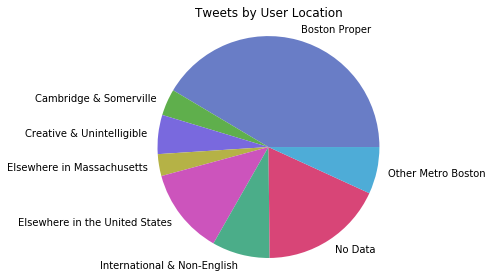

In [77]:
colors = ["#697dc6","#5faf4c","#7969de","#b5b246",
          "#cc54bc","#4bad89","#d84577","#4eacd7",
          "#cf4e33","#894ea8","#cf8c42","#d58cc9",
          "#737632","#9f4b75","#c36960"]

plt.pie( df_count_tweets['Count'], labels=df_count_tweets.index.get_values(),shadow=False, colors=colors)

plt.axis('equal')

plt.title('Tweets by User Location')

plt.tight_layout()
plt.show()

In [71]:
# Filtering tweets for those that are geotagged
df_tweetslatlon = df_somervilletweets[df_somervilletweets.lon.notnull() & df_somervilletweets.lat.notnull()]
df_tweetslatlon

,tweet_id,lat,lon,content,location
837668669039775745,837668669039775745,-71.119,42.3738,Cup #1 @ Harvard Square https://t.co/zpNJ70ghQ0,Somewhere North of Boston
837670087406465024,837670087406465024,-71.0589,42.3601,We're #hiring! Read about our latest #job open...,"Boston, MA"
837670608234143745,837670608234143745,-71.0648,42.4555,This #job might be a great fit for you: Barist...,"Boston, MA"
837672161426845698,837672161426845698,-71.1956,42.5047,Want to work at Sunrise Senior Living? We're #...,
837672754824396801,837672754824396801,-71.1368,42.452,"If you're looking for work in 542 Main St, #Wi...","Boston, MA"
837674507947151360,837674507947151360,-71.1052,42.309,Opened Pothole report via web at 3373 Washingt...,"Boston, MA"


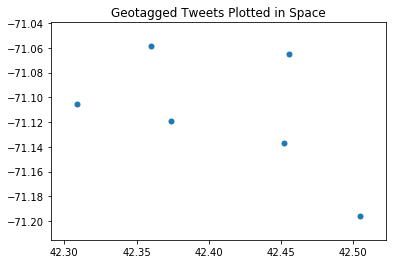

In [78]:

plt.scatter(df_tweetslatlon['lon'],df_tweetslatlon['lat'], s=25)
plt.title('Geotagged Tweets Plotted in Space')
plt.show()

In [6]:
search_term='Trump' 
latlong=[42.383434,-71.103069] # Spring Hill, Somerville, MA
# Setup a search distance
distance='25mi'
# Set result type (can be 'popular', 'popular', or 'mixed')
type_of_result='mixed'
# Set number of results (up to 100, remember you can only get 450 in 15 minutes)
number_of_tweets=5

def get_tweets_by_location( latlong=None ):
    results = my_twython.search(q=search_term, geocode=str(latlong[0])+','+str(latlong[1])+','+ distance, result_type=type_of_result, count=number_of_tweets)
    return results['statuses']

def get_lots_of_tweets( latlong ):
    all_tweets = {}
    
    # We will be hitting the API a number of times within the total time
    total_time = 900
    
    # Everytime we hit the API we subtract time from the total
    remaining_seconds = total_time
    interval = 10
    while remaining_seconds > 0: # loop and run the function while remaining seconds is greater than zero
        added = 0
        new_tweets = get_tweets_by_location(latlong)
        # Parse the resulting JSON, and save the rest of the raw content
        for tweet in new_tweets:
            tid = tweet['id']
            if tid not in all_tweets:
                properties = {}
                if tweet['coordinates'] != None:
                    properties['lat'] = tweet['coordinates']['coordinates'][0]
                    properties['lon'] = tweet['coordinates']['coordinates'][1]
                else:
                    properties['lat'] = None
                    properties['lon'] = None
                properties['location'] = tweet['user']['location'] #This will get us the location associated with the profile
                properties['tweet_id'] = tid
                properties['content'] = tweet['text']
                all_tweets[ tid ] = properties
                added += 1
        print("At %d seconds, added %d new tweets, for a total of %d" % ( total_time - remaining_seconds, added, len( all_tweets )))
        time.sleep(interval)
        remaining_seconds -= interval
    print(str(len(all_tweets)) + ' Tweets retrieved.')
    return all_tweets


# This function executes the the functions over a given period of time
def run_all():
    # This is the number of times the code will be executed. In this case, just once. 
    starting = 1
    while starting > 0:
        # Sometimes the API returns some errors, killing the whole script, so we setup try/except to make sure it keeps running
        try:
            t = get_lots_of_tweets( latlong )
            # We name every file with the current time
            timestr = time.strftime("%Y%m%d-%H%M%S")
            # We write a new JSON into the target path
            with open( 'data/' + '%stweets.json' %(timestr), 'w' ) as f:
                f.write(json.dumps(t))
            # we can use a library like threading to execute the run function continuously.
            #threading.Timer(10, run).start()
            starting -= 1
        except:
            pass
    
run_all()

At 0 seconds, added 3 new tweets, for a total of 3
At 10 seconds, added 0 new tweets, for a total of 3
At 20 seconds, added 0 new tweets, for a total of 3
At 30 seconds, added 0 new tweets, for a total of 3
At 40 seconds, added 0 new tweets, for a total of 3
At 50 seconds, added 0 new tweets, for a total of 3
At 60 seconds, added 0 new tweets, for a total of 3
At 70 seconds, added 0 new tweets, for a total of 3
At 80 seconds, added 2 new tweets, for a total of 5
At 90 seconds, added 0 new tweets, for a total of 5
At 100 seconds, added 1 new tweets, for a total of 6
At 110 seconds, added 0 new tweets, for a total of 6
At 120 seconds, added 0 new tweets, for a total of 6
At 130 seconds, added 0 new tweets, for a total of 6
At 140 seconds, added 0 new tweets, for a total of 6
At 150 seconds, added 0 new tweets, for a total of 6
At 160 seconds, added 0 new tweets, for a total of 6
At 170 seconds, added 0 new tweets, for a total of 6
At 180 seconds, added 0 new tweets, for a total of 6
At 1

In [36]:
file_dir = "data/PSET/search_term"

onlyfiles = [ f for f in listdir(file_dir) if isfile(join(file_dir,f)) and not f.startswith('.')]

df_trumpbostontweets = pd.DataFrame(columns = ['tweet_id', 'lat', 'lon', 'content','location'])

for file in onlyfiles:
    full_dir = join(file_dir,file) 
    with open(full_dir) as json_data:
        dict = json.load(json_data) 
        if not isinstance(dict, list):
            for key, val in dict.items():
                df_trumpbostontweets.loc[key,val] = val
                
df_trumpbostontweets

,tweet_id,lat,lon,content,location
837857282440429568,837857282440429568,None,None,So Trump's attempt to pass the buck for Yemen ...,
837456457213882373,837456457213882373,None,None,The whole Trump family is turning dad's electo...,
838005458535399424,838005458535399424,None,None,1/ Trump tries to take our eyes off how he &am...,
838023008719515648,838023008719515648,-71.0553,42.3561,Trump alleges Obama had Trump phones wiretappe...,"Boston, MA"
838022992391131142,838022992391131142,-71.0553,42.3561,President Trump alleged on Twitter on Saturday...,"Boston, MA"
838023063400742913,838023063400742913,None,None,Donald Trump is bad for business.,Greater Boston Area
838023625479438336,838023625479438336,None,None,I just feel like President Trump is beyond ins...,"Washington, DC"
838023695360798721,838023695360798721,None,None,At some point - mark my words - the defense in...,"Cambridge, MA"
838024203320373248,838024203320373248,None,None,"I think we all knew ""Presidential Trump"" was j...","Boston, MA"
838025792806350848,838025792806350848,None,None,Second episode - ❤👍🏼Awesome ministry! @jesuiti...,"Boston, MA"


In [37]:
df_trumpbostontweets.duplicated()

837857282440429568    False
837456457213882373    False
838005458535399424    False
838023008719515648    False
838022992391131142    False
838023063400742913    False
838023625479438336    False
838023695360798721    False
838024203320373248    False
838025792806350848    False
838026223452368896    False
838026333015977984    False
dtype: bool

In [38]:
df_trumpbostontweets.to_csv('tweets_re_trump_in_bos.csv', sep=',', encoding='utf-8')